In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.pyplot import figure
from plotly.subplots import make_subplots

from tabulate import tabulate
from skimage.transform import resize
from monai.transforms import Resize
from models.unet_multidim import BasicUNet

from scripts.run_test import get_overlay
from utils.tools import load_checkpoint, mask_to_bbox_volumetric
from data.multidim_multilabel_dataset import Image_Dataset
from preprocessing.organ_labels_v2_volumetric import selected_organ_labels

/home/eytan/miniconda3/envs/label/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
results_3d = '/home/eytan/storage/staff/eytankats/projects/orgloc/experiments/202507082234_multidim_multilabel_alllabels_weighted3_unet_processed_aggmasksv2/results_100.csv'
# results_25d = '/home/eytan/storage/staff/eytankats/projects/orgloc/experiments/202507141821_multidim_multilabel_alllabels_weighted5_25dim_unet_processed_aggmasksv2/results_30.csv'
results_25d = '/home/eytan/materials/orgloc/experiments/202507141821_multidim_multilabel_alllabels_weighted5_25dim_unet_processed_aggmasksv2/results_100.csv'
results_mm = '/home/eytan/storage/staff/eytankats/projects/orgloc/experiments/mean_model_wdice/results_100.csv'

df_3d = pd.read_csv(results_3d)#[:-2]
df_25d = pd.read_csv(results_25d)#[:-2]
df_mm = pd.read_csv(results_mm)


In [18]:
summary_3d = df_3d.agg(['mean', 'std']).transpose()
summary_25d = df_25d.agg(['mean', 'std']).transpose()
summary_mm = df_mm.agg(['mean', 'std']).transpose()

summary = pd.concat([summary_3d, summary_25d, summary_mm], axis=1)

# Rename the columns for clarity
summary.columns = [
    'mean Pix2Vox', 'std Pix2Vox',
    'mean CNN 2.5D', 'std CNN 2.5D',
    'mean Mean model', 'std Mean model',
]

# Remove row named 'name' and rows ending with 'mean'
summary = summary[~summary.index.to_series().astype(str).str.lower().eq('name')]
summary = summary[~summary.index.to_series().astype(str).str.lower().str.endswith('mean')]

# Sort index: move rows starting with "dice" and "sd" to the end
def sort_priority(index_val):
    prefix = str(index_val).lower()
    if prefix.startswith("dice") or prefix.startswith("sd"):
        return (1, prefix)  # Push to end
    else:
        return (0, prefix)  # Keep at beginning

summary = summary.sort_index(key=lambda idx: idx.map(sort_priority))

combined_df = pd.DataFrame(index=summary.index)

for model in ['Pix2Vox', 'CNN 2.5D', 'Mean model']:
    mean_col = f'mean {model}'
    std_col = f'std {model}'
    if mean_col in summary.columns and std_col in summary.columns:
        combined_df[model] = summary.apply(
            lambda row: (
                f"${row[mean_col]:.2f} \\pm {row[std_col]:.2f}$"
                if pd.notna(row[mean_col]) and pd.notna(row[std_col])
                else ""
            ),
            axis=1
        )

# First, make sure index has no underscores, as you do:
combined_df.index = combined_df.index.str.replace('_', ' ', regex=False)

# Group rows by the first word (prefix) of the index
from collections import defaultdict

tables_by_prefix = defaultdict(list)

for idx in combined_df.index:
    prefix = idx.split()[0].lower()  # Take the first word, lowercase for consistency
    tables_by_prefix[prefix].append(idx)

# Print separate LaTeX tables for each prefix
for prefix, rows in tables_by_prefix.items():
    subset_df = combined_df.loc[rows]
    latex_table = subset_df.to_latex(escape=False)
    print(f"% LaTeX table for prefix: {prefix}\n")
    print(latex_table)
    print("\n\n")


% LaTeX table for prefix: anterior

\begin{tabular}{llll}
\toprule
 & Pix2Vox & CNN 2.5D & Mean model \\
\midrule
anterior aorta & $12.42 \pm 8.13$ & $21.22 \pm 7.15$ & $-1.18 \pm 8.87$ \\
anterior clavicula left & $12.98 \pm 8.06$ & $21.32 \pm 7.76$ & $2.36 \pm 13.09$ \\
anterior clavicula right & $12.45 \pm 6.20$ & $20.18 \pm 6.29$ & $-1.83 \pm 7.68$ \\
anterior duodenum & $3.75 \pm 11.59$ & $17.76 \pm 9.83$ & $-23.83 \pm 7.30$ \\
anterior femur left & $14.18 \pm 9.08$ & $24.95 \pm 8.77$ & $-11.24 \pm 14.60$ \\
anterior femur right & $10.31 \pm 9.34$ & $23.64 \pm 8.52$ & $-8.46 \pm 8.70$ \\
anterior heart & $12.03 \pm 12.17$ & $24.66 \pm 10.76$ & $-4.62 \pm 15.19$ \\
anterior hip left & $6.30 \pm 8.71$ & $23.19 \pm 7.83$ & $-33.24 \pm 9.01$ \\
anterior hip right & $6.54 \pm 8.14$ & $21.61 \pm 7.96$ & $-38.59 \pm 5.97$ \\
anterior kidney left & $9.96 \pm 12.08$ & $20.86 \pm 11.93$ & $-5.34 \pm 12.27$ \\
anterior kidney right & $9.96 \pm 17.05$ & $19.39 \pm 16.74$ & $-6.00 \pm 7.91$ \\

In [6]:
print(tabulate(df_3d.head(10), headers='keys', tablefmt='psql'))

+----+--------+-------------+--------------+-----------------+-----------------+-----------------+------------------+-------------+-----------+---------------+----------------+-------------------+-------------------+-------------------+--------------------+---------------+-------------+---------------------+----------------------+-------------------------+-------------------------+-------------------------+--------------------------+---------------------+-------------------+--------------------+---------------------+------------------------+------------------------+------------------------+-------------------------+--------------------+------------------+--------------+---------------+------------------+------------------+------------------+-------------------+--------------+------------+----------------+-----------------+--------------------+--------------------+--------------------+---------------------+----------------+--------------+-----------------+------------------+------------

In [9]:
print(tabulate(df_25d.head(10), headers='keys', tablefmt='psql'))

+----+--------+-------------+--------------+-----------------+-----------------+-----------------+------------------+---------------+----------------+-------------------+-------------------+-------------------+--------------------+---------------------+----------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------+---------------------+------------------------+------------------------+------------------------+-------------------------+--------------+---------------+------------------+------------------+------------------+-------------------+----------------+-----------------+--------------------+--------------------+--------------------+---------------------+-----------------+------------------+---------------------+---------------------+---------------------+----------------------+-------------------+--------------------+-----------------------+-----------------------+-----------------------+--------

In [10]:
print(tabulate(df_mm.head(10), headers='keys', tablefmt='psql'))

+----+--------+-------------+--------------+-----------------+-----------------+-----------------+------------------+-------------+-----------+---------------+----------------+-------------------+-------------------+-------------------+--------------------+---------------+-------------+---------------------+----------------------+-------------------------+-------------------------+-------------------------+--------------------------+---------------------+-------------------+--------------------+---------------------+------------------------+------------------------+------------------------+-------------------------+--------------------+------------------+--------------+---------------+------------------+------------------+------------------+-------------------+--------------+------------+----------------+-----------------+--------------------+--------------------+--------------------+---------------------+----------------+--------------+-----------------+------------------+------------

In [3]:
def prepare_long_format_grouped_by_prefix(df, prefixes, suffixes=None, dataset_label='A'):
    rows = []
    for col in df.columns:
        for p in prefixes:
            if col.startswith(p + '_'):
                suffix = col[len(p) + 1:]
                if suffixes is not None and suffix not in suffixes:
                    continue
                rows.append({
                    'prefix': p,
                    'value': df[col].abs(),  # Absolute value
                    'dataset': dataset_label
                })
                break
    long_df = pd.concat([
        pd.DataFrame({
            'prefix': row['prefix'],
            'value': row['value'],
            'dataset': row['dataset']
        }) for row in rows
    ], ignore_index=True)
    return long_df


def plot_prefix_comparison_barplot(df_list, prefixes, suffixes=None,
                                     title='Prefix-Level Comparison',
                                     figsize=None,
                                     labels=('A', 'B', 'C'),
                                     y_label='',
                                     save_path=''):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Prepare long format for all datasets
    long_dfs = [
        prepare_long_format_grouped_by_prefix(df, prefixes, suffixes, dataset_label=label)
        for df, label in zip(df_list, labels)
    ]
    combined_df = pd.concat(long_dfs, ignore_index=True)

    # Compute mean and std per prefix and dataset
    agg_df = combined_df.groupby(['prefix', 'dataset']).agg(
        mean_value=('value', 'mean'),
        std_value=('value', 'std')
    ).reset_index()

    # Plotting
    ordered_prefixes = [p for p in prefixes if p in agg_df['prefix'].unique()]
    datasets = labels
    x = np.arange(len(ordered_prefixes))
    width = 0.8 / len(datasets)

    if figsize is None:
        figsize = (4, 6)
    fig, ax = plt.subplots(figsize=figsize)

    for i, dataset in enumerate(datasets):
        data = agg_df[agg_df['dataset'] == dataset].set_index('prefix').reindex(ordered_prefixes)
        means = data['mean_value']
        stds = data['std_value']
        pos_err = (np.zeros_like(stds), stds.values)

        ax.bar(
            x + i * width - (width * (len(datasets) - 1) / 2),
            means,
            width,
            yerr=pos_err,
            capsize=5,
            label=dataset,
            align='center'
        )

    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(ordered_prefixes, rotation=0)
    ax.legend(title='Method')

    plt.tight_layout()

    # --- Save to file if path is provided ---
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

    # --- Print mean ± std summary ---
    print("\nMean ± Std per Prefix:")
    for dataset in datasets:
        print(f"\nDataset: {dataset}")
        subset = agg_df[agg_df['dataset'] == dataset].set_index('prefix').reindex(ordered_prefixes)
        for prefix in ordered_prefixes:
            mean_val = subset.loc[prefix, 'mean_value']
            std_val = subset.loc[prefix, 'std_value']
            print(f"  {prefix:<15}: {mean_val:.2f} ± {std_val:.2f}")



Plot saved to /home/eytan/storage/staff/eytankats/projects/orgloc/plots/detetection_offset.pdf


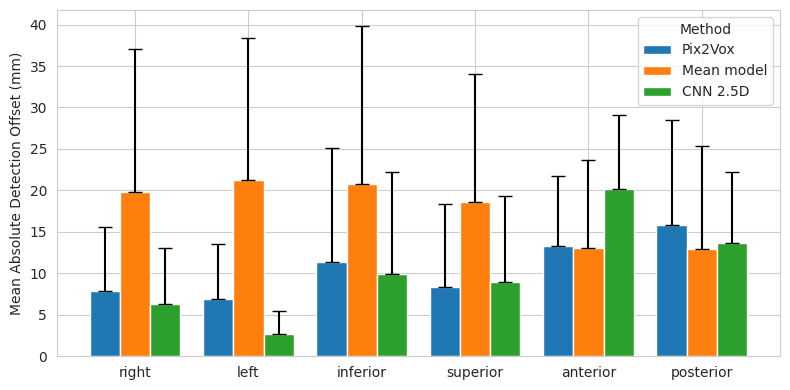


Mean ± Std per Prefix:

Dataset: Pix2Vox
  right          : 7.87 ± 7.69
  left           : 6.87 ± 6.62
  inferior       : 11.36 ± 13.71
  superior       : 8.39 ± 9.97
  anterior       : 13.29 ± 8.41
  posterior      : 15.87 ± 12.62

Dataset: Mean model
  right          : 19.86 ± 17.14
  left           : 21.23 ± 17.19
  inferior       : 20.71 ± 19.05
  superior       : 18.57 ± 15.41
  anterior       : 13.00 ± 10.63
  posterior      : 12.90 ± 12.48

Dataset: CNN 2.5D
  right          : 6.33 ± 6.72
  left           : 2.68 ± 2.79
  inferior       : 9.92 ± 12.35
  superior       : 8.96 ± 10.34
  anterior       : 20.14 ± 9.01
  posterior      : 13.65 ± 8.61


In [6]:
plot_prefix_comparison_barplot(
    [df_3d, df_mm, df_25d ],
    prefixes=['right', 'left', 'inferior', 'superior', 'anterior', 'posterior'],
    suffixes = None,
    labels=('Pix2Vox',  'Mean model', 'CNN 2.5D'),
    title='',
    y_label='Mean Absolute Detection Offset (mm)',
    figsize=(8, 4),
    save_path='/home/eytan/storage/staff/eytankats/projects/orgloc/plots/detetection_offset.pdf'
)

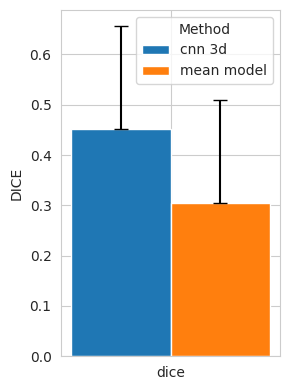


Mean ± Std per Prefix:

Dataset: cnn 3d
  dice           : 0.45 ± 0.20

Dataset: mean model
  dice           : 0.30 ± 0.20


In [6]:
plot_prefix_comparison_barplot(
    [df_3d, df_mm],
    prefixes=['dice'],
    suffixes = None,
    labels=('cnn 3d', 'mean model'),
    title='',
    y_label='DICE',
    figsize = (3, 4)
)

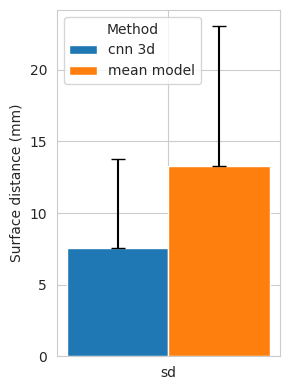


Mean ± Std per Prefix:

Dataset: cnn 3d
  sd             : 7.59 ± 6.21

Dataset: mean model
  sd             : 13.28 ± 9.74


In [7]:
plot_prefix_comparison_barplot(
    [df_3d, df_mm],
    prefixes=['sd'],
    suffixes = None,
    labels=('cnn 3d', 'mean model'),
    title='',
    y_label='Surface distance (mm)',
    figsize = (3, 4)
)

In [44]:
import pandas as pd
import re

def merge_left_right_columns(df):
    """
    Merge columns with '_left' and '_right' suffixes in a DataFrame by calculating their mean.
    If only one side exists, use it as-is. The new column is named by removing the side suffix.

    Parameters:
        df (pd.DataFrame): Input DataFrame

    Returns:
        pd.DataFrame: Modified DataFrame with merged columns
    """
    df = df.copy()
    columns = set(df.columns)
    merged = {}
    used_cols = set()

    # Find all _left/_right pairs
    for col in columns:
        if col.endswith('_left'):
            base = col[:-5]
            right_col = base + '_right'
            if right_col in columns:
                # Both sides exist
                merged[base] = df[[col, right_col]].mean(axis=1)
                used_cols.update([col, right_col])
            else:
                # Only left side
                merged[base] = df[col]
                used_cols.add(col)

        elif col.endswith('_right'):
            base = col[:-6]
            left_col = base + '_left'
            if left_col not in columns:
                # Only right side
                merged[base] = df[col]
                used_cols.add(col)

    # Add non-merged columns
    for col in df.columns:
        if col not in used_cols:
            merged[col] = df[col]

    # Construct new DataFrame in original column order where possible
    new_cols_order = []
    for col in df.columns:
        if col.endswith('_left') or col.endswith('_right'):
            base = re.sub(r'_(left|right)$', '', col)
            if base not in new_cols_order and base in merged:
                new_cols_order.append(base)
        elif col in merged and col not in new_cols_order:
            new_cols_order.append(col)

    # Include any additional merged keys
    for col in merged:
        if col not in new_cols_order:
            new_cols_order.append(col)

    return pd.DataFrame(merged)[new_cols_order]

def merge_vertebrae_columns_multiple_prefixes(df, prefixes):
    """
    For each prefix, merges vertebrae columns like '<prefix>_vertebrae_T*' and '<prefix>_vertebrae_L*'
    by computing the row-wise mean. Adds new columns like '<prefix>_vertebrae_t' and '<prefix>_vertebrae_l'.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        prefixes (list of str): List of prefixes to match (e.g., ['dice', 'haus'])

    Returns:
        pd.DataFrame: Modified DataFrame with merged vertebrae columns
    """
    df = df.copy()
    all_to_drop = []
    merged_data = {}

    for prefix in prefixes:
        # Find all matching thoracic and lumbar columns
        t_cols = [col for col in df.columns if re.fullmatch(f"{prefix}_vertebrae_T\\d+", col)]
        l_cols = [col for col in df.columns if re.fullmatch(f"{prefix}_vertebrae_L\\d+", col)]

        # Compute means
        if t_cols:
            merged_data[f"{prefix}_vertebrae_T"] = df[t_cols].mean(axis=1)
            all_to_drop.extend(t_cols)

        if l_cols:
            merged_data[f"{prefix}_vertebrae_L"] = df[l_cols].mean(axis=1)
            all_to_drop.extend(l_cols)

    # Drop the original vertebrae columns
    df.drop(columns=all_to_drop, inplace=True)

    # Add the merged columns
    df = pd.concat([df, pd.DataFrame(merged_data)], axis=1)

    return df

def prepare_long_format_2(df, prefixes, suffixes=None, dataset_label='A'):
    rows = []
    for col in df.columns:
        for p in prefixes:
            if col.startswith(p + '_'):
                suffix = col[len(p) + 1:]

                if suffixes is not None and suffix not in suffixes:
                    continue

                rows.append({
                    'column': col,
                    'value': df[col].abs(),
                    'dataset': dataset_label
                })
                break
    long_df = pd.concat([
        pd.DataFrame({
            'column': row['column'],
            'value': row['value'],
            'dataset': row['dataset']
        }) for row in rows
    ], ignore_index=True)
    return long_df

def get_ordered_columns(df, prefixes, suffixes=None):
    ordered = []
    for col in df.columns:
        for p in prefixes:
            if col.startswith(p + '_'):
                suffix = col[len(p) + 1:]
                if suffixes is None or suffix in suffixes:
                    ordered.append(col)
                    break
    return ordered

def plot_columns_stacked_barplot(df_list, prefixes, suffixes=None,
                                 title='Mean Absolute Error by Column',
                                 aspect_ratio=2.5,
                                 labels=None,
                                 y_label='',
                                 prefix_to_cut='',
                                 merge=False,
                                 column_name_map=None,
                                 save_path=''):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    if merge:
        df_list = [merge_left_right_columns(df) for df in df_list]
        df_list = [merge_vertebrae_columns_multiple_prefixes(df, prefixes) for df in df_list]

    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(df_list))]

    ordered_columns = get_ordered_columns(df_list[0], prefixes, suffixes)

    # Optional renaming of columns
    stripped_columns = [col[len(prefix_to_cut):] if col.startswith(prefix_to_cut) else col for col in ordered_columns]
    if column_name_map is not None:
        stripped_columns = [column_name_map.get(col, col) for col in ordered_columns]

    # Prepare long format
    long_dfs = [
        prepare_long_format_2(df, prefixes, suffixes, dataset_label=label)
        for df, label in zip(df_list, labels)
    ]
    combined_df = pd.concat(long_dfs, ignore_index=True)

    agg_df = combined_df.groupby(['column', 'dataset']).agg(
        mean_value=('value', 'mean'),
        std_value=('value', 'std')
    ).reset_index()

    x = np.arange(len(ordered_columns))  # positions for each group
    n = len(df_list)
    bar_width = 0.8 / n  # divide available space by number of bars per group

    fig, ax = plt.subplots(figsize=(aspect_ratio * 4, 6))

    error_colors = ['black', 'darkred', 'navy', 'darkgreen']
    cap_sizes = [5, 7, 9, 11]
    line_styles = ['solid', 'dotted', 'dashed', 'dashdot']

    for i, dataset in enumerate(labels):
        data = agg_df[agg_df['dataset'] == dataset].set_index('column').reindex(ordered_columns)

        means = data['mean_value'].values
        stds = data['std_value'].values
        bar_positions = x + (i - (n - 1) / 2) * bar_width  # center bars

        ax.bar(
            bar_positions,
            means,
            yerr=stds,
            capsize=cap_sizes[i % len(cap_sizes)],
            width=bar_width,
            label=dataset,
            align='center',
            alpha=0.85,
            color=None,  # Let matplotlib assign default colors
            edgecolor='black',
            error_kw=dict(
                ecolor=error_colors[i % len(error_colors)],
                elinewidth=1.5,
                linestyle=line_styles[i % len(line_styles)],
                capsize=cap_sizes[i % len(cap_sizes)],
            )
        )

    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(stripped_columns, rotation=45, ha='right')
    ax.legend(title='Method')
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.tight_layout()

    # --- Save to file if path is provided ---
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()



Plot saved to /home/eytan/storage/staff/eytankats/projects/orgloc/plots/dice.pdf


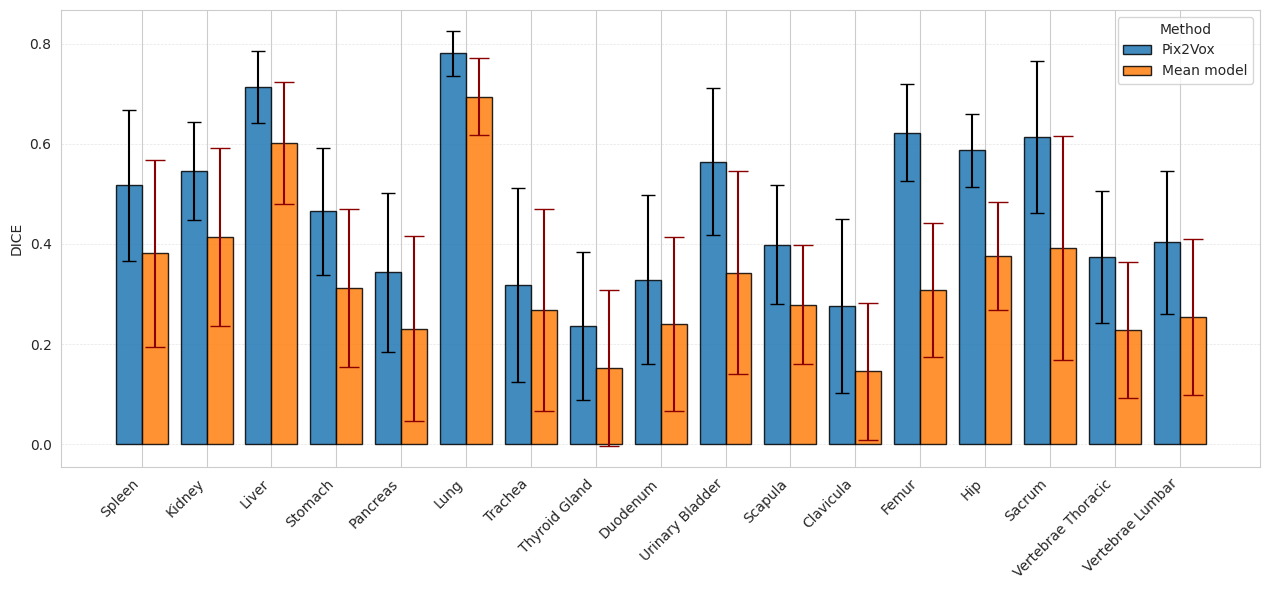

In [45]:
plot_columns_stacked_barplot(
    [df_3d, df_mm],
    prefixes=['dice'],
    suffixes = [
    "spleen",
    "kidney",
    "liver",
    "stomach",
    "pancreas",
    "lung",
    "trachea",
    "thyroid_gland",
    "duodenum",
    "urinary_bladder",
    "heart"
    "aorta",
    "scapula",
    "clavicula",
    "femur",
    "hip",
    "sacrum",
    "vertebrae_L",
    "vertebrae_T",
],
    labels=('Pix2Vox', 'Mean model'),
    title='',
    y_label='DICE',
    prefix_to_cut='dice_',
    aspect_ratio=3.2,
    merge=True,
    column_name_map={
    "dice_spleen": "Spleen",
    "dice_kidney": "Kidney",
    "dice_liver": "Liver",
    "dice_stomach": "Stomach",
    "dice_pancreas": "Pancreas",
    "dice_lung": "Lung",
    "dice_trachea": "Trachea",
    "dice_thyroid_gland": "Thyroid Gland",
    "dice_duodenum": "Duodenum",
    "dice_urinary_bladder": "Urinary Bladder",
    "dice_heart": "Heart",
    "dice_aorta": "Aorta",
    "dice_scapula": "Scapula",
    "dice_clavicula": "Clavicula",
    "dice_femur": "Femur",
    "dice_hip":"Hip",
    "dice_sacrum": "Sacrum",
    "dice_vertebrae_L": "Vertebrae Lumbar",
    "dice_vertebrae_T": "Vertebrae Thoracic",
    },
    save_path='/home/eytan/storage/staff/eytankats/projects/orgloc/plots/dice.pdf'
)

Plot saved to /home/eytan/storage/staff/eytankats/projects/orgloc/plots/sd.pdf


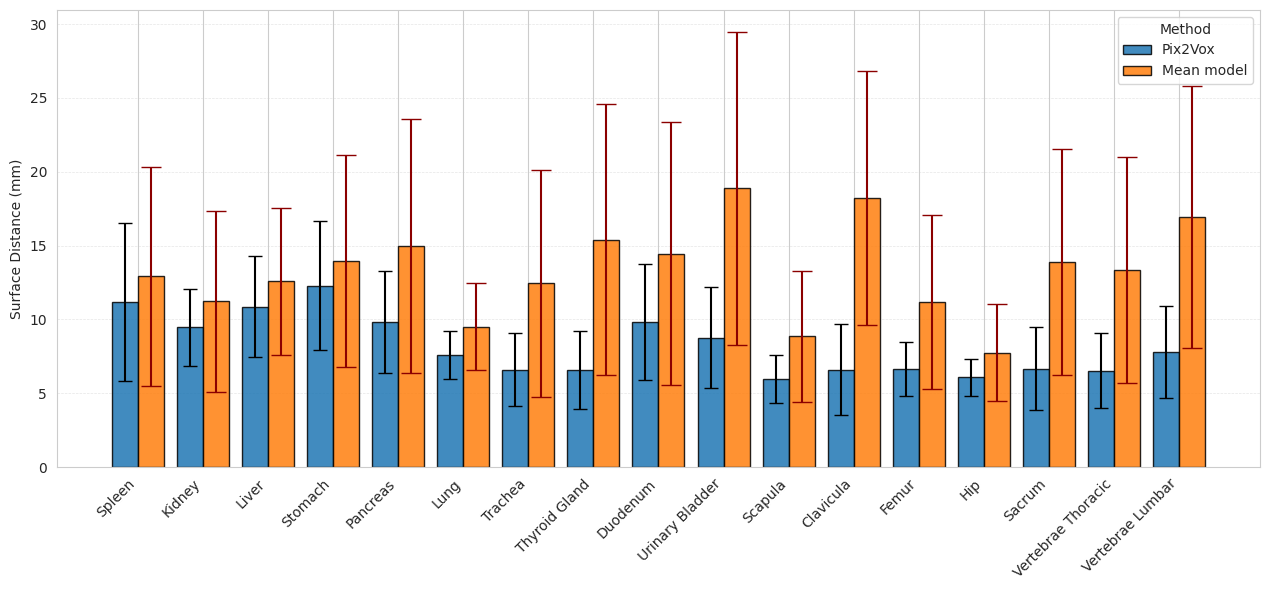

In [46]:
plot_columns_stacked_barplot(
    [df_3d, df_mm],
    prefixes=['sd'],
    suffixes = [
    "spleen",
    "kidney",
    "liver",
    "stomach",
    "pancreas",
    "lung",
    "trachea",
    "thyroid_gland",
    "duodenum",
    "urinary_bladder",
    "heart"
    "aorta",
    "scapula",
    "clavicula",
    "femur",
    "hip",
    "sacrum",
    "vertebrae_L",
    "vertebrae_T",
],
    labels=('Pix2Vox', 'Mean model'),
    title='',
    y_label='Surface Distance (mm)',
    prefix_to_cut='sd_',
    aspect_ratio=3.2,
    merge=True,
    column_name_map={
    "sd_spleen": "Spleen",
    "sd_kidney": "Kidney",
    "sd_liver": "Liver",
    "sd_stomach": "Stomach",
    "sd_pancreas": "Pancreas",
    "sd_lung": "Lung",
    "sd_trachea": "Trachea",
    "sd_thyroid_gland": "Thyroid Gland",
    "sd_duodenum": "Duodenum",
    "sd_urinary_bladder": "Urinary Bladder",
    "sd_heart": "Heart",
    "sd_aorta": "Aorta",
    "sd_scapula": "Scapula",
    "sd_clavicula": "Clavicula",
    "sd_femur": "Femur",
    "sd_hip":"Hip",
    "sd_sacrum": "Sacrum",
    "sd_vertebrae_L": "Vertebrae Lumbar",
    "sd_vertebrae_T": "Vertebrae Thoracic",
    },
    save_path='/home/eytan/storage/staff/eytankats/projects/orgloc/plots/sd.pdf'
)

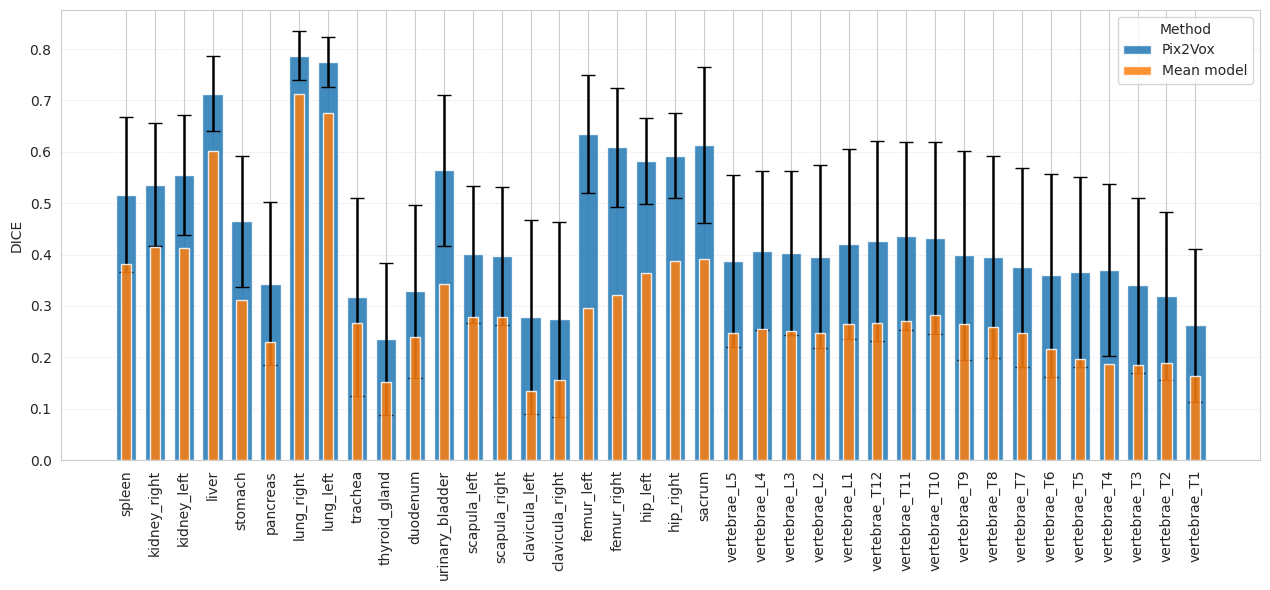

In [6]:
plot_columns_stacked_barplot(
    [df_3d, df_mm],
    prefixes=['dice'],
    suffixes = [
    "spleen",
    "kidney_right",
    "kidney_left",
    "liver",
    "stomach",
    "pancreas",
    "lung_right",
    "lung_left",
    "trachea",
    "thyroid_gland",
    "duodenum",
    "urinary_bladder",
    "heart"
    "aorta",
    "scapula_left",
    "scapula_right",
    "clavicula_left",
    "clavicula_right",
    "femur_left",
    "femur_right",
    "hip_left",
    "hip_right",
    "sacrum",
    "vertebrae_L5",
    "vertebrae_L4",
    "vertebrae_L3",
    "vertebrae_L2",
    "vertebrae_L1",
    "vertebrae_T12",
    "vertebrae_T11",
    "vertebrae_T10",
    "vertebrae_T9",
    "vertebrae_T8",
    "vertebrae_T7",
    "vertebrae_T6",
    "vertebrae_T5",
    "vertebrae_T4",
    "vertebrae_T3",
    "vertebrae_T2",
    "vertebrae_T1",
],
    labels=('Pix2Vox', 'Mean model'),
    title='',
    y_label='DICE',
    prefix_to_cut='dice_',
    aspect_ratio=3.2,

)

In [2]:
test_data_file_path = '/home/eytan/materials/orgloc/data/nako_10k/masks_volumetric_preprocessed_v2/test_masks_list.csv'
images_dir = '/home/eytan/storage/staff/eytankats/data/nako_10k/images_depth/'
volumes_dir = '/home/eytan/storage/staff/eytankats/data/nako_10k/images_mri_stitched/'
masks_dir = '/home/eytan/materials/orgloc/data/nako_10k/masks_volumetric_preprocessed_v2/'
masks_pattern = '/home/eytan/materials/orgloc/data/nako_10k/masks_volumetric_preprocessed_v2/*.nii.gz'
labels_file = '/home/eytan/storage/staff/eytankats/data/nako_10k/labels_processed_aggregated_v2.json'
experiment_dir = '/home/eytan/materials/orgloc/experiments/202507061131_multidim_multilabel_alllabels_30000steps_unet_processed_aggmasksv2'
ckpt_path = '/home/eytan/materials/orgloc/experiments/202507061131_multidim_multilabel_alllabels_30000steps_unet_processed_aggmasksv2/checkpoints/best_valid_loss.pth'

In [7]:
# Initialize dataset and model
test_dataset = Image_Dataset(test_data_file_path, images_dir=images_dir, masks_pattern=masks_pattern,
                                 labels_file=labels_file, stage='test')

model = BasicUNet(in_channels=3, out_channels=len(selected_organ_labels) + 1, dropout=False)
model = load_checkpoint(model, ckpt_path)

BasicUNet features: (64, 64, 128, 256, 512).
BasicUNet features: (16, 16, 32, 64, 128, 16).


In [11]:
def save_outliers(df, anatomy, side, ascending=True, vis_num=1):

    df_anatomy_side = df[['name', f'{side}_{anatomy}']]
    df_anatomy_side = df_anatomy_side.sort_values(by=f'{side}_{anatomy}', ascending=ascending)

    outliers_dir = os.path.join(experiment_dir, 'outliers', anatomy, side)
    os.makedirs(outliers_dir, exist_ok=True)

    for idx in range(0, vis_num):
        save_seg(df_anatomy_side.iloc[idx]['name'], outliers_dir, anatomy)

    print(tabulate(df_anatomy_side.head(vis_num), headers='keys', tablefmt='psql'))

In [9]:
def save_seg(sample, outliers_dir, anatomy):

    anatomy_idx = selected_organ_labels.index(anatomy)
    data_idx = test_dataset.name_list.index(sample)
    data = test_dataset[data_idx]

    img_rgb = data['img'].unsqueeze(0)

    if (img_rgb == 0).all():
        print(f'sample {sample} is all 0')
        return

    img_rgb = img_rgb / 255.0
    img_rgb = 2. * img_rgb - 1.

    seg_img = torch.stack(data['seg'], dim=0).float()
    seg_img = seg_img.unsqueeze(0).float()

    with torch.no_grad():
        pred_seg = torch.nn.functional.sigmoid(model(img_rgb))

    pred_resize_transform = Resize(spatial_size=(390, 480, 948))

    pred_anatomy = pred_seg[0, anatomy_idx + 1, :, :, :]
    pred_anatomy = pred_resize_transform(pred_anatomy.unsqueeze(0)).squeeze().detach().cpu().numpy()
    pred_anatomy_thr = np.float32(pred_anatomy > 0.5)

    path_to_save_pred = os.path.join(outliers_dir, f'{sample}_pred.nii.gz')
    pred_anatomy_nib = nib.Nifti1Image(pred_anatomy_thr.astype(np.float32), np.eye(4))
    nib.save(pred_anatomy_nib, path_to_save_pred)

    seg_anatomy = torch.zeros_like(seg_img)
    seg_anatomy[seg_img == anatomy_idx + 1] = 1
    seg_anatomy = seg_anatomy.squeeze()

    gt_resize_transform = Resize(spatial_size=(390, 480, 948), mode='nearest')
    seg_anatomy = gt_resize_transform(seg_anatomy.unsqueeze(0)).squeeze().numpy()

    path_to_save_gt = os.path.join(outliers_dir, f'{sample}_gt.nii.gz')
    seg_anatomy_nib = nib.Nifti1Image(seg_anatomy, np.eye(4))
    nib.save(seg_anatomy_nib, path_to_save_gt)

    volume_path = os.path.join(volumes_dir, sample, 'wat.nii.gz')
    volume = nib.load(volume_path).get_fdata()
    volume = np.flip(volume, axis=1)
    volume = torch.from_numpy(volume.copy()).float().permute(1, 0, 2)
    volume = pred_resize_transform(volume.unsqueeze(0)).squeeze().numpy()

    path_to_save_vol = os.path.join(outliers_dir, f'{sample}_vol.nii.gz')
    volume = nib.Nifti1Image(volume, np.eye(4))
    nib.save(volume, path_to_save_vol)


In [15]:
save_outliers(df, 'spleen', 'inferior', ascending=False, vis_num=2)

sample 111278 is all 0
+-----+--------+-------------------+
|     |   name |   inferior_spleen |
|-----+--------+-------------------|
| 211 | 111278 |               379 |
| 151 | 104282 |                86 |
+-----+--------+-------------------+
